In [ ]:
'''
VGG16 Ablation
'''

# Imports

In [1]:
#To hide warnings exhttps://ec2-54-172-177-181.compute-1.amazonaws.com:8889/notebooks/code/models/vgg16_lesion.ipynb#port PYTHONWARNINGS="ignore"
#Imports{
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from keras import layers
from keras import models
import keras.utils as keras_utils
from keras.layers import Lambda

from  keras.applications import imagenet_utils
from  keras.applications.imagenet_utils import decode_predictions
from  keras_applications.imagenet_utils import _obtain_input_shape

import os
from os.path import dirname
from os.path import join
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Cha


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
    
import pickle
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from imageio import imread
from skimage.transform import resize
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cluster import MiniBatchKMeans

import gc
import keras
import tensorflow as tf
from keras import backend as K
from keras.applications.vgg16 import preprocess_input
import PIL.Image
#}

Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/p37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/envs/p37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/envs/p37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ec2-user/anaconda

# Model Definition

In [2]:
model_name = 'VGG16'

In [3]:
#Code snippet needed to read activation values from each layer of the pre-trained artificial neural networks
def get_activations(model, layer, X_batch):
    #keras.backend.function(inputs, outputs, updates=None)
    get_activations = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()], [model.layers[layer].output,])
    #The learning phase flag is a bool tensor (0 = test, 1 = train)
    activations = get_activations([X_batch,0])
    return activations

In [4]:
preprocess_input = imagenet_utils.preprocess_input

WEIGHTS_PATH = ('https://github.com/fchollet/deep-learning-models/'
                'releases/download/v0.1/'
                'vgg16_weights_tf_dim_ordering_tf_kernels.h5')
WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                       'releases/download/v0.1/'
                       'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')


def VGG16(include_top=True,
          weights='imagenet',
          input_tensor=None,
          input_shape=None,
          pooling=None,
          classes=1000,
          lambda_mask=None,
          **kwargs):
    
    backend= keras.backend
    layers = keras.layers
    models = keras.models
    keras_utils = tf.keras.utils
    
    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(img_input)
    ####################
    if lambda_mask is not None:
        block_1_conv_1_mask  = np.reshape(lambda_mask[0:3211264], (224, 224,64))
    else:
        block_1_conv_1_mask = np.ones(shape=((224, 224, 64)))
    
    block_1_conv_1_mask  = backend.variable(block_1_conv_1_mask)
    block_1_conv_1_lambda = Lambda(lambda x: x * block_1_conv_1_mask)(x)
    ####################
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(block_1_conv_1_lambda)
    ####################
    if lambda_mask is not None:
        block_1_conv_2_mask  = np.reshape(lambda_mask[3211264:6422528], (224, 224, 64))
    else:
        block_1_conv_2_mask = np.ones(shape=((224, 224, 64)))
    
    block_1_conv_2_mask  = backend.variable(block_1_conv_2_mask)
    block_1_conv_2_lambda = Lambda(lambda x: x * block_1_conv_2_mask)(x)
    ####################
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(block_1_conv_2_lambda)

    # Block 2
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    ####################
    if lambda_mask is not None:
        block_2_conv_1_mask  = np.reshape(lambda_mask[6422528:8028160], (112, 112, 128))
    else:
        block_2_conv_1_mask = np.ones(shape=((112, 112, 128)))
    
    block_2_conv_1_mask  = backend.variable(block_2_conv_1_mask)
    block_2_conv_1_lambda = Lambda(lambda x: x * block_2_conv_1_mask)(x)
    ####################
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(block_2_conv_1_lambda)
    
    ####################
    if lambda_mask is not None:
        block_2_conv_2_mask  = np.reshape(lambda_mask[8028160:9633792], (112, 112, 128))
    else:
        block_2_conv_2_mask = np.ones(shape=((112, 112, 128)))
    
    block_2_conv_2_mask  = backend.variable(block_2_conv_2_mask)
    block_2_conv_2_lambda = Lambda(lambda x: x * block_2_conv_2_mask)(x)
    ####################
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(block_2_conv_2_lambda)

    # Block 3
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    ####################
    if lambda_mask is not None:
        block_3_conv_1_mask  = np.reshape(lambda_mask[9633792:10436608], (56, 56, 256))
    else:
        block_3_conv_1_mask = np.ones(shape=((56, 56, 256)))
    
    block_3_conv_1_mask  = backend.variable(block_3_conv_1_mask)
    block_3_conv_1_lambda = Lambda(lambda x: x * block_3_conv_1_mask)(x)
    ####################
    
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(block_3_conv_1_lambda)
    ####################
    if lambda_mask is not None:
        block_3_conv_2_mask  = np.reshape(lambda_mask[10436608:11239424], (56, 56, 256))
    else:
        block_3_conv_2_mask = np.ones(shape=((56, 56, 256)))
    ####################
    block_3_conv_2_mask  = backend.variable(block_3_conv_2_mask)
    block_3_conv_2_lambda = Lambda(lambda x: x * block_3_conv_2_mask)(x)
    
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')( block_3_conv_2_lambda)
    ####################
    if lambda_mask is not None:
        block_3_conv_3_mask  = np.reshape(lambda_mask[11239424:12042240], (56, 56, 256))
    else:
        block_3_conv_3_mask = np.ones(shape=((56, 56, 256)))
    ####################
    block_3_conv_3_mask  = backend.variable(block_3_conv_3_mask)
    block_3_conv_3_lambda = Lambda(lambda x: x * block_3_conv_3_mask)(x)
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(block_3_conv_3_lambda)

    # Block 4
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
    ####################
    if lambda_mask is not None:
        block_4_conv_1_mask  = np.reshape(lambda_mask[12042240:12443648], (28, 28, 512))
    else:
        block_4_conv_1_mask = np.ones(shape=((28, 28, 512)))
    
    block_4_conv_1_mask  = backend.variable(block_4_conv_1_mask)
    block_4_conv_1_lambda = Lambda(lambda x: x * block_4_conv_1_mask)(x)
    ####################
    
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(block_4_conv_1_lambda)
    ####################
    if lambda_mask is not None:
        block_4_conv_2_mask  = np.reshape(lambda_mask[12443648:12845056], (28, 28, 512))
    else:
        block_4_conv_2_mask = np.ones(shape=((28, 28, 512)))
    
    block_4_conv_2_mask  = backend.variable(block_4_conv_2_mask)
    block_4_conv_2_lambda = Lambda(lambda x: x * block_4_conv_2_mask)(x)
    ####################
    
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(block_4_conv_2_lambda)
    
    ####################
    if lambda_mask is not None:
        block_4_conv_3_mask  = np.reshape(lambda_mask[12845056:13246464], (28, 28, 512))
    else:
        block_4_conv_3_mask = np.ones(shape=((28, 28, 512)))
    
    block_4_conv_3_mask  = backend.variable(block_4_conv_3_mask)
    block_4_conv_3_lambda = Lambda(lambda x: x * block_4_conv_3_mask)(x)
    ####################
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')( block_4_conv_3_lambda)

    # Block 5
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv1')(x)
    ####################
    if lambda_mask is not None:
        block_5_conv_1_mask  = np.reshape(lambda_mask[13246464:13346816], (14, 14, 512))
    else:
        block_5_conv_1_mask = np.ones(shape=((14, 14, 512)))
    
    block_5_conv_1_mask  = backend.variable(block_5_conv_1_mask)
    block_5_conv_1_lambda = Lambda(lambda x: x * block_5_conv_1_mask)(x)
    ####################
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv2')(block_5_conv_1_lambda)
    ####################
    if lambda_mask is not None:
        block_5_conv_2_mask  = np.reshape(lambda_mask[13346816:13447168], (14, 14, 512))
    else:
        block_5_conv_2_mask = np.ones(shape=((14, 14, 512)))
    
    block_5_conv_2_mask  = backend.variable(block_5_conv_2_mask)
    block_5_conv_2_lambda = Lambda(lambda x: x * block_5_conv_2_mask)(x)
    ####################
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3')(block_5_conv_2_lambda)
    ####################
    if lambda_mask is not None:
        block_5_conv_3_mask  = np.reshape(lambda_mask[13447168:13547520], (14, 14, 512))
    else:
        block_5_conv_3_mask = np.ones(shape=((14, 14, 512)))

    block_5_conv_3_mask  = backend.variable(block_5_conv_3_mask)
    block_5_conv_3_lambda = Lambda(lambda x: x * block_5_conv_3_mask)(x)
    ####################
    
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')( block_5_conv_3_lambda)

    if include_top:
        # Classification block
        x = layers.Flatten(name='flatten')(x)
        x = layers.Dense(4096, activation='relu', name='fc1')(x)
        ####################
        if lambda_mask is not None:
            block_fc1_mask  = np.reshape(lambda_mask[13547520:13551616], (4096,))
        else:
            block_fc1_mask = np.ones(shape=((4096,)))
        block_fc1_mask  = backend.variable(block_fc1_mask)
        block_fc1_lambda = Lambda(lambda x: x * block_fc1_mask)(x)
        ####################
        x = layers.Dense(4096, activation='relu', name='fc2')(block_fc1_lambda)
        ####################
        if lambda_mask is not None:
            block_fc2_mask  = np.reshape(lambda_mask[13551616:13555712], (4096,))
        else:
            block_fc2_mask = np.ones(shape=((4096,)))
        block_fc2_mask  = backend.variable(block_fc2_mask)
        block_fc2_lambda = Lambda(lambda x: x * block_fc2_mask)(x)
        ####################
        x = layers.Dense(classes, activation='softmax', name='predictions')(block_fc2_lambda)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='vgg16')

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            weights_path = keras_utils.get_file(
                'vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                file_hash='64373286793e3c8b2b4e3219cbf3544b')
        else:
            weights_path = keras_utils.get_file(
                'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                file_hash='6d6bbae143d832006294945121d1f1fc')
        model.load_weights(weights_path)
        if backend.backend() == 'theano':
            keras_utils.convert_all_kernels_in_model(model)
    elif weights is not None:
        model.load_weights(weights)

    return model

In [5]:
#Function to pre-process the input image to ensure uniform size and color
def preprocess_image_batch(image_paths, img_size=None, crop_size=None, color_mode='rgb', out=None):
    """
    Consistent preprocessing of images batches
    :param image_paths: iterable: images to process
    :param crop_size: tuple: crop images if specified
    :param img_size: tuple: resize images if specified
    :param color_mode: Use rgb or change to bgr mode based on type of model you want to use
    :param out: append output to this iterable if specified
    """
    img_list = []

    for im_path in image_paths:
        size = 224
        ret = PIL.Image.open(im_path)
        ret = ret.resize((size, size))
        ret = np.asarray(ret, dtype=np.uint8).astype(np.float32)
        #ret[:, :, 0] -= 123.68
        #ret[:, :, 1] -= 116.779
        #ret[:, :, 2] -= 103.939
        if ret.ndim == 2:
            ret.resize((size, size, 1))
            ret = np.repeat(ret, 3, axis=-1)
        #ret = ret.transpose((2, 0, 1))
        #ret = np.flip(ret,0)
        x = preprocess_input(ret)
        #print(x.shape)
        img_list.append(x)
        

    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        print(im_path)
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')

    if out is not None and hasattr(out, 'append'):
        out.append(img_batch)
    else:
        return img_batch

In [6]:
#Function to predict the top 5 accuracy
def top5accuracy(true, predicted):
    assert len(true) == len(predicted)
    result = []
    flag  = 0
    for i in range(len(true)):
        flag  = 0
        temp = true[i]
        for j in predicted[i][0:5]:
            if j == temp:
                flag = 1
                break
        if flag == 1:
            result.append(1)
        else:
            result.append(0)
    counter = 0.
    for i in result:
        if i == 1:
            counter += 1.
    error = 1.0 - counter/float(len(result))
    #print len(np.where(np.asarray(result) == 1)[0])
    return len(np.where(np.asarray(result) == 1)[0]), error

In [7]:
#Load the details of all the 1000 classes and the function to conver the synset id to words{
meta_clsloc_file = '../../data/meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

def id_to_words(id_):
    return synsets[corr_inv[id_] - 1][2][0]

def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:10]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
    #print('%.2f' % round(100 * out[u], 2) + ' : ' + id_to_words(u)+' '+ str(synsets[corr_inv[u] - 1][1][0]))
    return wids

In [8]:
#Code snippet to load the ground truth labels to measure the performance{
truth = {}
with open('../../data/ILSVRC2014_clsloc_validation_ground_truth.txt') as f:
    line_num = 1
    for line in f.readlines():
        ind_ = int(line)
        temp  = None
        for i in synsets_imagenet_sorted:
            if i[0] == ind_:
                temp = i
        #print ind_,temp
        if temp != None:
            truth[line_num] = temp
        else:
            print('##########', ind_)
            pass
        line_num += 1
#}

# Step 0 - Getting activations and saving them into pkl files

In [ ]:
# Loading the folder to be procesed from command line{
p = 'inanimate'
tmp = p.replace('/','_')
print(tmp)


p_num = 1
url_path = '../../data/'+p+'/'
#}

In [ ]:
# Prepare the image list and pre-process them{
true_wids = []
im_list = []
for i in os.listdir(url_path):
    if not i.startswith('~') and not i.startswith('.'):
        #print i, truth
        temp = i.split('.')[0].split('_')[2]
        true_wids.append(truth[int(temp)][1])
        im_list.append(url_path+i)

im = preprocess_image_batch(im_list,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
#}


In [ ]:
# Model parmeters and running the model from the loaded weights{
model_name = 'VGG16'
model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, 
              lambda_mask = np.ones(13555712),
              classes=1000)
#KFold
k = 4

im_train, im_test = train_test_split(im_list, test_size=0.2, random_state=42)
#}

In [ ]:
#Training data pkl
fp_name = '../../data/pkl_vgg16/'+str(p)+'_train_no_lesion_performance.txt'
fp = open(fp_name,'a+')
im_temp = preprocess_image_batch(im_train,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
out = model.predict(im_temp)

true_valid_wids = []
for i in im_train:
        temp1 = i.split('/')[4]
        temp = temp1.split('.')[0].split('_')[2]
        true_valid_wids.append(truth[int(temp)][1])

predicted_valid_wids = []
for i in range(len(im_train)):
    #print(im_list[i], pprint_output(out[i]), true_wids[i])
    predicted_valid_wids.append(pprint_output(out[i]))

count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

fp.write(str(p)+' '+str(count)+' '+str(len(im_train))+' '+str(error)+'\n')


print(len(true_valid_wids), len(predicted_valid_wids), len(im_train))
print(count, error)


#}
# Code snippet to get the activation values and saving information{
data = np.array([])

i = 0
result ={}
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        activations = get_activations(model,i,im_temp)
        if result.get(layer.name, None) is None:
            result[layer.name] = activations[0]
            temp = np.mean(activations[0], axis=0).ravel()
            if layer.name != 'predictions':
                print(layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape)
                data = np.append(data, temp)
    i += 1

fp.close()
with open('../../data/pkl_vgg16/'+str(p)+'_train_'+model_name+'.pkl', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
#Testing data pkl
fp_name = '../../data/pkl_vgg16/'+str(p)+'_test_no_lesion_performance.txt'
fp = open(fp_name,'a+')

im_temp = preprocess_image_batch(im_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
out = model.predict(im_temp,batch_size=64)

true_valid_wids = []
for i in im_test:
        temp1 = i.split('/')[4]
        temp = temp1.split('.')[0].split('_')[2]
        true_valid_wids.append(truth[int(temp)][1])

predicted_valid_wids = []
for i in range(len(im_test)):
    #print im_list[i], pprint_output(out[i]), true_wids[i]
    predicted_valid_wids.append(pprint_output(out[i]))

count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

fp.write(str(p)+' '+str(count)+' '+str(len(im_test))+' '+str(error)+'\n')


print(len(true_valid_wids), len(predicted_valid_wids), len(im_test))
print(count, error)


#}
# Code snippet to get the activation values and saving information{
data = np.array([])

i = 0
result ={}
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        activations = get_activations(model,i,im_temp)
        if result.get(layer.name, None) is None:
            result[layer.name] = activations[0]
            temp = np.mean(activations[0], axis=0).ravel()
            if layer.name != 'predictions':
                print(layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape)
                data = np.append(data, temp)
    i += 1

fp.close()
with open('../../data/pkl_vgg16/'+str(p)+'_test_'+model_name+'.pkl', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
out_r = []

image_list_test = '../../data/pkl_vgg16/'+p+'_image_list_test.txt'
with open(image_list_test,'w+') as f:
    for i in im_test:
        f.write(i+'\n')

kf = KFold(n_splits= k)
fold = 1
fp_name = '../../data/pkl_vgg16/'+str(p)+'_no_lesion_performance.txt'
fp = open(fp_name,'a+')
for train_index, valid_index in kf.split(im_train):
    print("Starting Fold: ", fold)
    im_valid_train = [im_train[i] for i in train_index] 
    im_valid_test = [im_train[i] for i in valid_index]
    
    image_list_train = '../../data/pkl_vgg16/'+p+'_image_list_train_fold_'+str(fold)+'.txt'
    with open(image_list_train,'w+') as f:
        for i in im_valid_train:
            f.write(i+'\n')
    
    image_list_valid = '../../data/pkl_vgg16/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
    with open(image_list_valid,'w+') as f:
        for i in im_valid_test:
            f.write(i+'\n')
    
   
    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    out = model.predict(im_temp,batch_size=64)

    true_valid_wids = []
    for i in im_valid_test:
            temp1 = i.split('/')[4]
            temp = temp1.split('.')[0].split('_')[2]
            true_valid_wids.append(truth[int(temp)][1])
    
    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        #print im_list[i], pprint_output(out[i]), true_wids[i]
        predicted_valid_wids.append(pprint_output(out[i]))
        
    count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)
    
    fp.write(str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+'\n')

    
    print(len(true_valid_wids), len(predicted_valid_wids), len(im_valid_test))
    print(count, error)
    
    
    #}
    # Code snippet to get the activation values and saving information{
    data = np.array([])

    i = 0
    result ={}
    for layer in model.layers:
        weights = layer.get_weights()
        if len(weights) > 0:
            activations = get_activations(model,i,im_temp)
            if result.get(layer.name, None) is None:
                result[layer.name] = activations[0]
                temp = np.mean(activations[0], axis=0).ravel()
                if layer.name != 'predictions':
                    print(layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape)
                    data = np.append(data, temp)
        i += 1
    print(data.shape)
    out_r.append(data)
    fold += 1
    
fp.close()

In [ ]:
#Saving all the data into pkl files
for i in range(k):
    name = p+'_fold_'+str(i+1)+'_train_'+model_name
    out_data = out_r[i]
    with open('../../data/pkl_vgg16/'+name+'.pkl', 'wb') as f:
        pickle.dump(out_data, f)
    print(name, len(out_data))

In [9]:
import gc
from keras import backend as K 

#del model
K.clear_session()
gc.collect()

100

# Step 1 - Cross-Validation to find best value of k and corresponding indices

In [ ]:
#%%time
#Version 1 - Reading pkl files from step 0 and clustering it{
data_path = '../../data/pkl_vgg16/'
classes = ['animate','inanimate']

from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.mixture import GaussianMixture

result= {}

model_name = 'VGG16'
k = 4 #Total Number of folds
fold = 1

for i in range(k):
    
#     if fold == 1:
#         fold +=1
#         continue
    print('Perfoming Fold: ', fold)
    clf_result = {}
    
    if os.path.exists('../../data/pkl_vgg16/kmeans_first_'+str(fold)+'_'+model_name+'.pkl'):
        with open('../../data/pkl_vgg16/kmeans_first_'+str(fold)+'_'+model_name+'.pkl',"rb") as f:
            X_new,pred_kmeans,kmeans = pickle.load(f)
    else:   
        with open(data_path+classes[0]+'_fold_'+str(fold)+'_train_'+model_name+'.pkl','rb') as f:
            X_fold = pickle.load(f)
        with open(data_path+classes[1]+'_fold_'+str(fold)+'_train_'+model_name+'.pkl','rb') as f:
            y_fold = pickle.load(f)

        X = np.column_stack((X_fold,y_fold))
        kmeans = MiniBatchKMeans(n_clusters=67783, random_state=42).fit(X) #200x Reduction in cluster size
        #print kmeans.cluster_centers_
        pred_kmeans = kmeans.predict(X)
        X_new = kmeans.cluster_centers_

        with open('../../data/pkl_vgg16/kmeans_first_'+str(fold)+'_'+model_name+'.pkl', 'wb') as handle:
            pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

    #DO CLUSTERING AND GET CLUSTERS
    
    
    method ='GMM'
    print(method)
    for j in range(1,13,1):
 
        clf_result[j] = {}
        print(j,2**j)
        #clf = KMeans(n_clusters=j)    
        clf = GaussianMixture(n_components=2**j, covariance_type='full', random_state=42)
        y_pred = clf.fit_predict(X_new)
        #print clf.cluster_centers_

        for label in set(y_pred):
            print('Cluster: ',j,'Label: ', label)
            
            #Lesioning and measuring performance
            pred = y_pred.copy()
            loc = np.where(pred==label)
            loc_temp = kmeans.predict(X_new[loc[0]])
            loc_new =[]
            for entry in set(loc_temp):
                temp = np.where(pred_kmeans==entry)[0]
                loc_new.extend(temp)

            lambda_mask = np.ones(shape=((13555712,)))
            lambda_mask[loc_new] = 0.

            #plt.scatter(X[:,0],X[:,1], c=y_pred) 
            #Change Model
            model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)

            flag = 0
            dprime = 0.
            for p in classes:
                im_valid_test = []
                image_list_valid = '../../data/pkl_vgg16/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
                with open(image_list_valid,'r') as f:
                    for line in f.readlines():
                        im_valid_test.append(line.strip('\n'))
                im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
                out = model.predict(im_temp,batch_size=64)

                true_valid_wids = []
                for i in im_valid_test:
                        temp1 = i.split('/')[4]
                        temp = temp1.split('.')[0].split('_')[2]
                        true_valid_wids.append(truth[int(temp)][1])

                predicted_valid_wids = []
                for i in range(len(im_valid_test)):
                    #print im_list[i], pprint_output(out[i]), true_wids[i]
                    predicted_valid_wids.append(pprint_output(out[i]))

                count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

                print(str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error))
                
                if flag == 0:
                    dprime = error
                    flag = 1
                else:
                    dprime -= error
                    
            keras.backend.clear_session()
            gc.collect()
            del model
            clf_result[j][label] = [dprime,loc_new]
    
    with open('../../data/pkl_vgg16/'+str(method)+'_multi_scree_fold_'+str(fold)+'_'+model_name+'.pkl', 'wb') as handle:
        pickle.dump(clf_result, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    result[fold] = clf_result
    fold += 1
#}

In [10]:
#Code to generate average scree plot
model_name = 'VGG16'
method = 'GMM'
folder_name='pkl_vgg16'
number_of_neurons = 13555712
k = 4
result ={}
for i in range(1,k+1,1):
    name = '../../data/'+folder_name+'/'+str(method)+'_multi_scree_fold_'+str(i)+'_'+model_name+'.pkl'   #CHANGE
    with open(name,"rb") as f:
        result[i] = pickle.load(f)

In [11]:
from functools import reduce
import itertools
fold = 1
loc_ana = {}
loc_ina = {}
pi_ana = {}
pi_ina = {}
loc_ana_avg = []
loc_ina_avg = []
for i in range(4):
    pi_scores = [i for i in result[fold][3].values()]
    pi_scores_ina = [i for i in result[fold][5].values()]
    #ana = int(list(pi_scores).index(max(pi_scores)))
    #ina = int(list(pi_scores).index(min(pi_scores)))
    ana = sorted(range(len(pi_scores)), key=lambda i: pi_scores[i],reverse=True)[0:12]
    ina = sorted(range(len(pi_scores)), key=lambda i: pi_scores_ina[i])[0:50]
    pi_ana[fold] = [result[fold][3][i][1] for i in ana]
    pi_ina[fold] = [result[fold][5][i][1] for i in ina]
    #print(fold, ana, ana_mppi_score)
    #print('####',fold, ina, ina_mppi_score)
    #print(fold, ina, [result_validate[fold][256][i][1] for i in ina])
#     loc_ana[fold] =  list(itertools.chain.from_iterable([result[fold][8][i][1] for i in ana]))
#     loc_ina[fold] = list(itertools.chain.from_iterable([result[fold][9][i][1] for i in ina]))
    fold+=1
# loc_ana_avg = list(reduce(set.intersection, [set(item) for item in loc_ana.values()]))
# loc_ina_avg = list(reduce(set.intersection, [set(item) for item in loc_ina.values()]))
# print(len(loc_ana_avg),len(loc_ina_avg))

In [ ]:
cl, len(clf_result[cl])

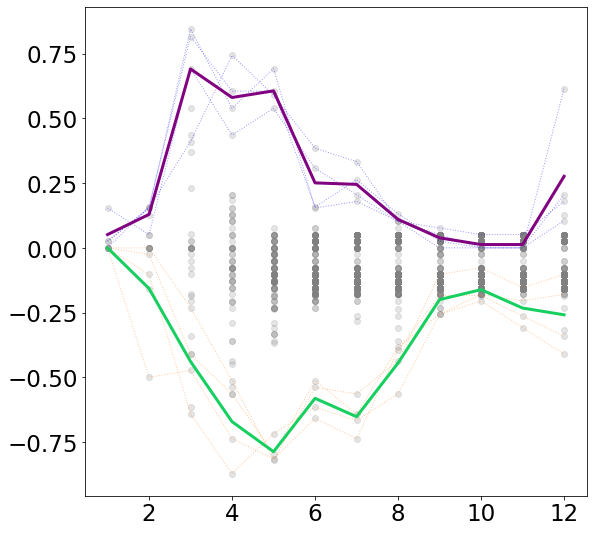

In [13]:
fig = plt.figure(1,figsize=(9,9))
ax1 = fig.add_subplot(111)
anat_avg = np.zeros(12,)
inat_avg = np.zeros(12,)
for f in range(1,5,1):
    clf_result = result[f]
    X = range(1,13,1)
    xticks = []
    x2ticks = []
    anat = []
    inat = []
    for cl in X:
        xticks.append(2**cl)
        x2ticks.append(number_of_neurons//2**cl)
        i = 0
        temp = []
        for item in clf_result[cl].keys():
            if cl == 3:
                if clf_result[cl][item][0] in pi_ana[f]:
                    plt.plot(cl,clf_result[cl][item][0],'go',color='#800080')
                elif clf_result[cl][item] in pi_ina[f]:
                    plt.plot(cl,clf_result[cl][item][0],'go',color='#15CF5F')
                else:
                    plt.plot(cl,clf_result[cl][item][0],'go',color='grey',alpha=0.2)
            else:
                plt.plot(cl,clf_result[cl][item][0],'go',color='grey',alpha=0.2)
            temp.append(clf_result[cl][item][0])
            i += 1
        anat.append(np.max(temp))
        inat.append(np.min(temp))
     
    anat_avg = np.add(anat_avg,anat)
    inat_avg = np.add(inat_avg,inat)
    plt.plot(X,anat, color='b',linewidth=1, alpha=0.4,linestyle='dotted')
    plt.plot(X,inat, color='C1',linewidth=1,alpha=0.4,linestyle='dotted')

for i in range(12):
    anat_avg[i] = anat_avg[i] / 4.
    inat_avg[i] = inat_avg[i] / 4.
    
plt.plot(X,anat_avg, color='#800080',linewidth=3,label='Animate')
plt.plot(X,inat_avg, color='#15CF5F',linewidth=3, label ='Inanimate')

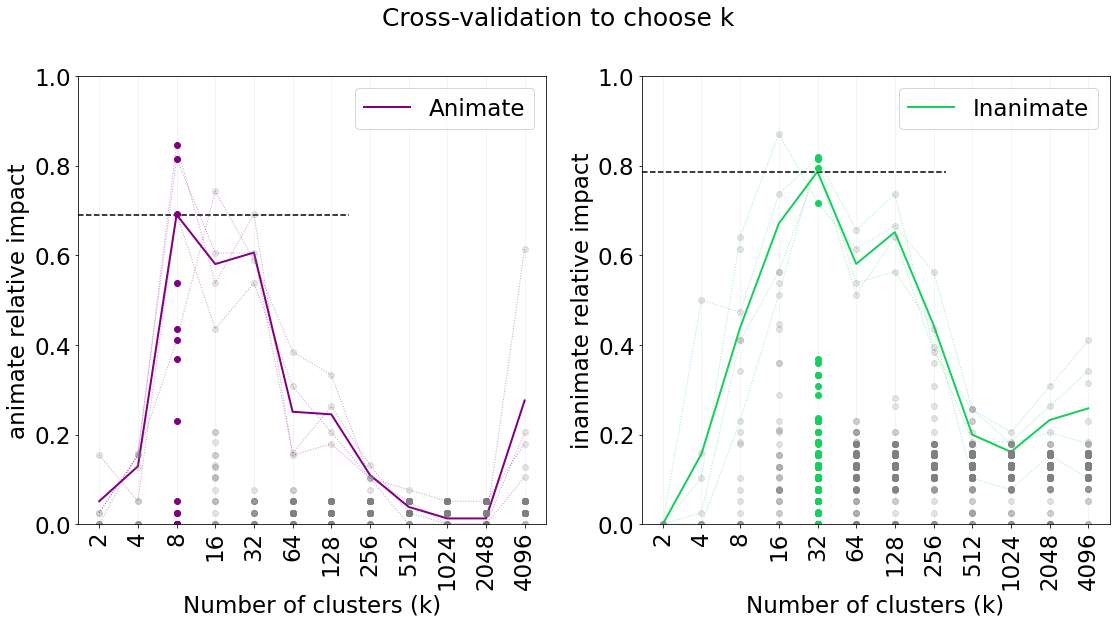

In [14]:
fig, ax = plt.subplots(figsize=(16,9))
matplotlib.rcParams["font.size"] = 23
fig.suptitle('Cross-validation to choose k', fontsize=25)


plt.subplot(1, 2, 1)
plt.plot(range(1,13,1), anat_avg, color='#800080', linewidth=2, label='Animate')
plt.grid(axis='x', color='0.95')
plt.xticks(range(1,13,1),xticks, rotation=90)
plt.axhline(y=max(anat_avg), color='black', linestyle='--', xmin=0, xmax=0.58)
plt.ylim([0,1])
plt.ylabel('animate relative impact')
plt.xlabel('Number of clusters (k)')

for f in range(1,5,1):
    clf_result = result[f]
    X = range(1,13,1)
    anat = []
    for cl in X:
        i = 0
        temp =[]
        for item in clf_result[cl].keys():
            if cl == 3:
                plt.plot(cl,clf_result[cl][item][0],'go',color='#800080')
            else:
                plt.plot(cl,clf_result[cl][item][0],'go',color='grey',alpha=0.2)
            i += 1
            temp.append(clf_result[cl][item][0])
        anat.append(np.max(temp))
    plt.plot(range(1,13,1),anat, color='#800080',linewidth=1, alpha=0.4,linestyle='dotted')
plt.legend()

inat_avg_pos = -1 * inat_avg
plt.subplot(1, 2, 2)
plt.plot(range(1,13,1), inat_avg_pos, color='#15CF5F', linewidth=2, label='Inanimate')
plt.grid(axis='x', color='0.95')
plt.xticks(range(1,13,1),xticks, rotation=90)
plt.axhline(y=max(inat_avg_pos), color='black', linestyle='--', xmin=0, xmax=0.65)
plt.ylabel('inanimate relative impact')
plt.xlabel('Number of clusters (k)')
plt.ylim([0,1])

for f in range(1,5,1):
    clf_result = result[f]
    X = range(1,13,1)
    inat = []
    for cl in X:
        i = 0
        temp =[]
        for item in clf_result[cl].keys():
            if cl == 5:
                plt.plot(cl,-1*clf_result[cl][item][0],'go',color='#15CF5F') 
            else:
                plt.plot(cl,-1*clf_result[cl][item][0],'go',color='grey',alpha=0.2)
            i += 1
            temp.append(-1*clf_result[cl][item][0])
        inat.append(np.max(temp))
    plt.plot(range(1,13,1),inat, color='#15CF5F',linewidth=1, alpha=0.4,linestyle='dotted')
plt.legend()

plt.tight_layout()
#plt.savefig('../../../vgg16_cross_fold.png')

In [ ]:
import gc
from keras import backend as K 
del model
K.clear_session()
gc.collect()

# Step 2 - Using the k from Step 1 to do the final groupings

In [9]:
folder = 'pkl_vgg16'
model_name = 'VGG16'
debug = False

In [19]:
#%%time
#Testing on test data{
data_path = '../../data/pkl_vgg16/'
classes = ['animate','inanimate']

result = {}

print('Loading pkls')
with open(data_path+classes[0]+'_test_'+model_name+'.pkl','rb') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_test_'+model_name+'.pkl','rb') as f:
        y_fold = pickle.load(f)

print('First level clustering')
X = np.column_stack((X_fold,y_fold))  
if os.path.exists('../../data/pkl_vgg16/kmeans_first_test_'+model_name+'.pkl'):
    with open('../../data/pkl_vgg16/kmeans_first_test_'+model_name+'.pkl',"rb") as f:
        X_new,pred_kmeans,kmeans = pickle.load(f)
else:   
   
    kmeans = MiniBatchKMeans(n_clusters=65827,
                             random_state=42,
                             batch_size=6,
                             max_iter=10).fit(X)
    #print kmeans.cluster_centers_
    pred_kmeans = kmeans.predict(X)
    X_new = kmeans.cluster_centers_
    with open('../../data/pkl_vgg16/kmeans_first_test_'+model_name+'.pkl', 'wb') as handle:
        pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

#DO CLUSTERING AND GET CLUSTERS

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

j = 32  #Set this value from scree plot!
method = 'GMM'
print(j)

clf = GaussianMixture(n_components=j, covariance_type='full',random_state=42)
temp = clf.fit(X_new)
y_pred = clf.predict(X_new)
#y_pred = clf.fit_predict(X_new)
print(set(y_pred))
#Z = clf.predict(X)

for label in set(y_pred):
    print('Cluster: ',j,'Label: ', label)

    #Lesioning and measuring performance
    pred = y_pred.copy()
    loc = np.where(pred==label)
    loc_temp = kmeans.predict(X_new[loc[0]])
    loc_new =[]
    for entry in set(loc_temp):
        temp = np.where(pred_kmeans==entry)[0]
        loc_new.extend(temp)

    lambda_mask = np.ones(shape=((13555712,)))
    lambda_mask[loc_new] = 0.

    #plt.scatter(X[:,0],X[:,1], c=y_pred) 
    model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)
    
    flag = 0
    dprime = 0.
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/pkl_vgg16/'+p+'_image_list_test.txt'
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")

        out = model.predict(im_temp,batch_size=32)
       
        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

        if flag == 0:
            dprime = error
            flag = 1
        else:
            dprime -= error
    keras.backend.clear_session()
    gc.collect()
    del model

    result[label] = [dprime,loc_new]

Loading pkls
First level clustering
32
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
Cluster:  32 Label:  0
animate 38 39 0.02564102564102566 0.9743589743589743
inanimate 30 39 0.23076923076923073 0.7692307692307693
Cluster:  32 Label:  1
animate 6 39 0.8461538461538461 0.15384615384615385
inanimate 30 39 0.23076923076923073 0.7692307692307693
Cluster:  32 Label:  2
animate 37 39 0.05128205128205132 0.9487179487179487
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cluster:  32 Label:  3
animate 38 39 0.02564102564102566 0.9743589743589743
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  32 Label:  4
animate 38 39 0.02564102564102566 0.9743589743589743
inanimate 31 39 0.20512820512820518 0.7948717948717948
Cluster:  32 Label:  5
animate 37 39 0.05128205128205132 0.9487179487179487
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cluster:  32 Label:  6
animate 38 39 0.02564102564102566 0.

In [20]:
list(result.values()),X.shape

([[-0.20512820512820507,
   [3259821,
    3369817,
    3406425,
    4051794,
    4123730,
    4267410,
    4383058,
    4520226,
    4522341,
    4565074,
    4682066,
    4764434,
    4792978,
    4949869,
    5155090,
    5286866,
    5313618,
    5428114,
    5612370,
    5667602,
    6287513,
    6358681,
    6501726,
    6531536,
    6615081,
    6625837,
    6630180,
    6642443,
    6727954,
    6730216,
    6764378,
    6818696,
    6828974,
    6831464,
    6851165,
    6931941,
    6936384,
    6973598,
    7062021,
    7097615,
    7112495,
    7124302,
    7162725,
    7173989,
    7222338,
    7228745,
    7242313,
    7297091,
    7327826,
    7347566,
    7493859,
    7531994,
    7554653,
    7564242,
    7581917,
    7620679,
    7649058,
    7668562,
    7697213,
    7775205,
    7825328,
    7834910,
    7946478,
    8044776,
    8131594,
    8292965,
    8330278,
    8368443,
    8377018,
    8418428,
    8430719,
    8441180,
    8443032,
    8498534,
    8521442,


In [24]:
x = X[:,0]
y = X[:,1]

In [25]:
z_temp = []
for item in y_pred:
    z_temp.append(result[item][0])
print(len(z_temp),len(X_new))
loc_z = kmeans.predict(X_new)
z = np.ones(shape=((13555712,)))
for i in range(len(loc_z)):
    temp = np.where(pred_kmeans==loc_z[i])[0]
    z[temp] = z_temp[i]

65827 65827


In [34]:
with open('../../data/'+folder+'/kmeans_first_test_8_cluster'+model_name+'.pkl',"rb") as f:
        result, y_pred_kmeans,z  = pickle.load(f)

In [30]:
with open('../../data/'+folder+'/kmeans_first_test_32_cluster'+model_name+'.pkl', 'wb') as handle:
        pickle.dump([result,y_pred, z], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
print(list(result.values()).index(max(result.values())), list(result.values()).index(min(result.values())))
ana_8 = int(list(result.values()).index(max(result.values())))
ina_8 = int(list(result.values()).index(min(result.values())))
print(result[ana_8][0], -1*(result[ina_8][0]))

3 0
0.5641025641025641 0.6410256410256411


In [28]:
print(list(result.values()).index(max(result.values())), list(result.values()).index(min(result.values())))
ana_32 = int(list(result.values()).index(max(result.values())))
ina_32 = int(list(result.values()).index(min(result.values())))
print(result[ana_32][0], -1*(result[ina_32][0]))

1 29
0.6153846153846154 0.8974358974358975


In [23]:
loc_ana_avg = []
loc_ina_avg = []

In [36]:
loc_ana_avg = result[ana_8][1]
print(len(loc_ana_avg))

522735


In [31]:
loc_ina_avg = result[ina_32][1]
print(len(loc_ina_avg))

1182446


In [37]:
test_loc_ana_avg = loc_ana_avg
test_loc_ina_avg = loc_ina_avg
print(len(test_loc_ana_avg),len(test_loc_ina_avg))

522735 1182446


In [38]:
spax = []
spay = []
for i in range(0,len(z)):
    if z[i] == result[ana_8][0]:
        spax.append(x[i])
        spay.append(y[i])

spax = np.asarray(spax)
spay = np.asarray(spay)

In [33]:
spix = []
spiy = []
for i in range(0,len(z)):
    if z[i] == result[ina_32][0]:
        spix.append(x[i])
        spiy.append(y[i])

spix = np.asarray(spix)
spiy = np.asarray(spiy)

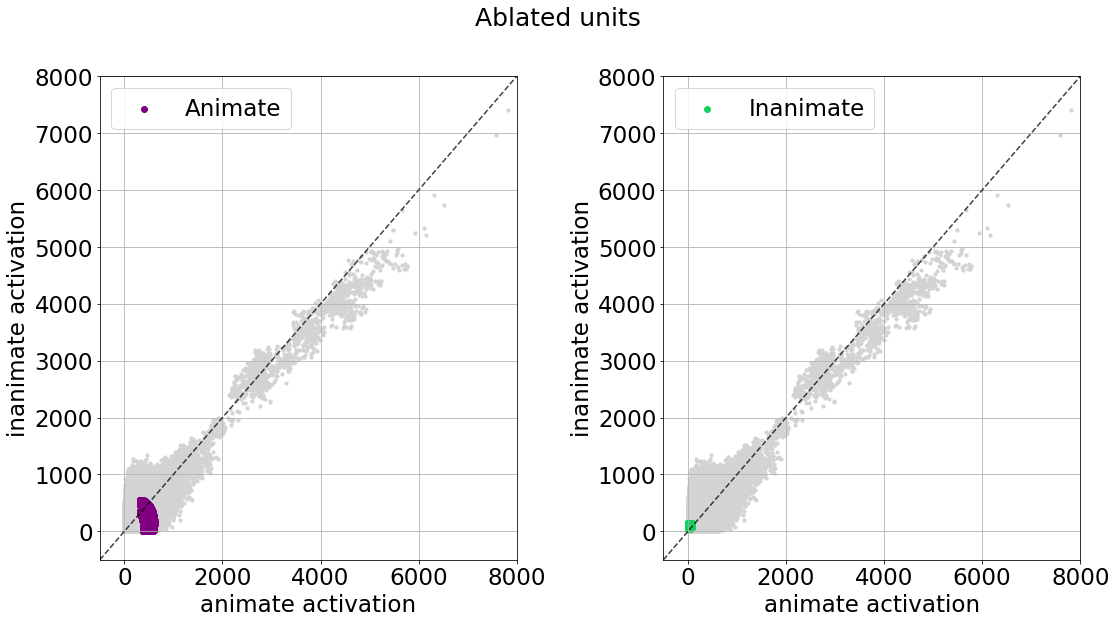

In [40]:
fig, ax = plt.subplots(figsize=(16,9))
matplotlib.rcParams["font.size"] = 23
fig.suptitle('Ablated units', fontsize=25)


plt.subplot(1, 2, 1)
plt.scatter(x,y, c='lightgray', s=10,vmin=-1, vmax=1)
plt.scatter(spax, spay, label='Animate',color='#800080')
plt.plot([-500,8000],[-500,8000], 'k--', color='black', alpha=0.75)
plt.xlim([-500,8000])
plt.ylim([-500,8000])
plt.ylabel('inanimate activation')
plt.xlabel('animate activation')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter( x,y, c='lightgray', s=10,vmin=-1, vmax=1)
plt.scatter(spix, spiy, color='#15CF5F', label='Inanimate')
plt.plot([-500,8000],[-500,8000], 'k--', color='black', alpha=0.75)
plt.xlim([-500,8000])
plt.ylim([-500,8000])
plt.ylabel('inanimate activation')
plt.xlabel('animate activation')
plt.grid()
plt.legend()


plt.tight_layout()
plt.savefig('../../vgg16_scatter.png')

In [ ]:
layer_info = {}
#Comparing Layer lesions
classes = ['animate','inanimate']
%time
for label in [ana,ina]:
    layer_info[label] = {}
    for layer in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
        if layer == 1:
            start = 0
            end = 3211264
        elif layer == 2:
            start = 3211264
            end = 6422528
        elif layer == 3:
            start = 6422528
            end = 8028160
        elif layer == 4:
            start = 8028160
            end = 9633792
        elif layer == 5:
            start = 9633792
            end = 10436608
        elif layer == 6:
            start = 10436608
            end = 11239424
        elif layer == 7:
            start = 11239424
            end = 12042240
        elif layer == 8:
            start = 12042240
            end = 12443648
        elif layer == 9:
            start = 12443648
            end = 12845056
        elif layer == 10:
            start = 12845056
            end = 13246464
        elif layer == 11:
            start = 13246464
            end = 13346816
        elif layer == 12:
            start = 13346816
            end = 13447168
        elif layer == 13:
            start = 13447168
            end = 13547520
        elif layer == 14:
            start = 13547520
            end = 13551616
        elif layer == 15:
            start = 13551616
            end = 13555712

        layer_info[label][layer] = {}
    
        #No lesion
        #print('No-lesioning')
        #print('Label:',label)
        #print('Layer:',layer)

        pred = clf.predict(X_new)
        lambda_mask = np.ones(shape=((13555712,)))
       

        model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)

        flag = 0
        dprime = 0.
        for p in classes:
            im_valid_test = []
            image_list_valid = '../../data/pkl/'+p+'_image_list_test.txt'
            with open(image_list_valid,'r') as f:
                for line in f.readlines():
                    im_valid_test.append(line.strip('\n'))
            im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
            out = model.predict(im_temp,batch_size=64)

            true_valid_wids = []
            for i in im_valid_test:
                    temp1 = i.split('/')[4]
                    temp = temp1.split('.')[0].split('_')[2]
                    true_valid_wids.append(truth[int(temp)][1])

            predicted_valid_wids = []
            for i in range(len(im_valid_test)):
                #print im_list[i], pprint_output(out[i]), true_wids[i]
                predicted_valid_wids.append(pprint_output(out[i]))

            count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

            print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))
              
            if flag == 0:
                dprime = error
                flag = 1
            else:
                dprime -= error
        print('Layer: ',layer,'Label: ', label)
        print('No lesion: ',dprime)
        layer_info[label][layer]['no'] = dprime
        
        tf.keras.backend.clear_session()
        gc.collect()
        del model
        #Before lesion
        #print('Pre-layer-lesioning')
        #print('Label:',label)
        #print('Layer:',layer)

        pred = clf.predict(X_new)
        loc = np.where(pred==label)[0]
        loc_new =[]
        for i in range(len(loc)):
            temp = np.where(pred_kmeans==loc[i])[0]
            loc_new.extend(temp)

        lambda_mask = np.ones(shape=((13555712,)))
        lambda_mask[loc_new] = 0.
        print('pre-loc', len(loc_new))
        model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)

        flag = 0
        dprime = 0.
        for p in classes:
            im_valid_test = []
            image_list_valid = '../../data/pkl/'+p+'_image_list_test.txt'
            with open(image_list_valid,'r') as f:
                for line in f.readlines():
                    im_valid_test.append(line.strip('\n'))
            im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
            out = model.predict(im_temp,batch_size=64)

            true_valid_wids = []
            for i in im_valid_test:
                    temp1 = i.split('/')[4]
                    temp = temp1.split('.')[0].split('_')[2]
                    true_valid_wids.append(truth[int(temp)][1])

            predicted_valid_wids = []
            for i in range(len(im_valid_test)):
                #print im_list[i], pprint_output(out[i]), true_wids[i]
                predicted_valid_wids.append(pprint_output(out[i]))

            count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

            print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

            if flag == 0:
                dprime = error
                flag = 1
            else:
                dprime -= error
        print('Cluster Only: ',dprime)
        layer_info[label][layer]['pre'] = dprime   
        tf.keras.backend.clear_session()
        gc.collect()
        del model
             
            
        #After Lesion
       # print('Post-layer-lesioning')
        #print('Label:',label)
        #print('Layer:',layer)
        pred = clf.predict(X_new)
        loc = np.where(pred==label)[0]
        loc_new =[]
        for i in range(len(loc)):
            temp = np.where(pred_kmeans==loc[i])[0]
            temp2 = temp[np.asarray(np.where((temp >end) | (temp <=start))[0])]
            #print(len(temp), len(temp2))
            loc_new.extend(temp2)


        lambda_mask = np.ones(shape=((13555712,)))
        lambda_mask[loc_new] = 0.
        print('post-loc', len(loc_new))
        model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)

        flag = 0
        dprime = 0.
        for p in classes:
            im_valid_test = []
            image_list_valid = '../../data/pkl/'+p+'_image_list_test.txt'
            with open(image_list_valid,'r') as f:
                for line in f.readlines():
                    im_valid_test.append(line.strip('\n'))
            im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
            out = model.predict(im_temp,batch_size=64)

            true_valid_wids = []
            for i in im_valid_test:
                    temp1 = i.split('/')[4]
                    temp = temp1.split('.')[0].split('_')[2]
                    true_valid_wids.append(truth[int(temp)][1])

            predicted_valid_wids = []
            for i in range(len(im_valid_test)):
                #print im_list[i], pprint_output(out[i]), true_wids[i]
                predicted_valid_wids.append(pprint_output(out[i]))

            count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

            print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

            if flag == 0:
                dprime = error
                flag = 1
            else:
                dprime -= error
        print('Cluster - layer: ',dprime)
        layer_info[label][layer]['post'] = dprime
        
        
         #Random Lesion
       # print('Post-layer-lesioning')
        #print('Label:',label)
        #print('Layer:',layer)
        pred = clf.predict(X_new)
        loc = np.where(pred==label)[0]
        loc_new =[]
        for i in range(len(loc)):
            temp = np.where(pred_kmeans==loc[i])[0]
            temp2 = temp[np.asarray(np.where((temp >end) | (temp <=start))[0])]
            #print(len(temp), len(temp2))
            loc_new.extend(temp2)

        loc_new2 = np.random.randint(start,end,len(loc_new))
        lambda_mask = np.ones(shape=((13555712,)))
        lambda_mask[loc_new2] = 0.
        print('post-rand-loc', len(loc_new))
        model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)

        flag = 0
        dprime = 0.
        for p in classes:
            im_valid_test = []
            image_list_valid = '../../data/pkl/'+p+'_image_list_test.txt'
            with open(image_list_valid,'r') as f:
                for line in f.readlines():
                    im_valid_test.append(line.strip('\n'))
            im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
            out = model.predict(im_temp,batch_size=64)

            true_valid_wids = []
            for i in im_valid_test:
                    temp1 = i.split('/')[4]
                    temp = temp1.split('.')[0].split('_')[2]
                    true_valid_wids.append(truth[int(temp)][1])

            predicted_valid_wids = []
            for i in range(len(im_valid_test)):
                #print im_list[i], pprint_output(out[i]), true_wids[i]
                predicted_valid_wids.append(pprint_output(out[i]))

            count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

            print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

            if flag == 0:
                dprime = error
                flag = 1
            else:
                dprime -= error
        print('Random: ',dprime)
        layer_info[label][layer]['rand'] = dprime
        tf.keras.backend.clear_session()
        gc.collect()
        del model
       

In [ ]:
import gc
keras.backend.clear_session()
gc.collect()
if 'model' in locals():
    del model

# Step 3 - Generating Salience figures

In [ ]:
#Pre-trained model - Without lesion
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                    weights="imagenet",input_tensor=None, pooling=None, 
                    classifier_activation="softmax", classes=1000)

In [ ]:
#Pre-trained model - With lesion
'''
label=ana
#print(label,result[label])
pred = clf.predict(X_new)
loc = np.where(pred==label)
loc_temp = kmeans.predict(X_new[loc[0]])
loc_new =[]
for entry in set(loc_temp):
    temp = np.where(pred_kmeans==entry)[0]
    loc_new.extend(temp)
'''
lambda_mask = np.ones(shape=((5725552,)))
print(len(loc_ana_avg),' out of 5725552')
lambda_mask[loc_ana_avg] = 0.
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                    weights="imagenet",input_tensor=None, pooling=None, 
                    classes=1000, classifier_activation="softmax", lambda_mask=lambda_mask)

In [ ]:
image_list_valid = '../../data/pkl_mobile/animate_MobileNetV2_image_list_test.txt'
im_valid_test = []
with open(image_list_valid,'r') as f:
    for line in f.readlines():
        im_valid_test.append(line.strip('\n'))
        
im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
out = model.predict(im_temp,batch_size=64)

true_valid_wids = []
for i in im_valid_test:
        temp1 = i.split('/')[4]
        temp = temp1.split('.')[0].split('_')[2]
        true_valid_wids.append(truth[int(temp)][1])

predicted_valid_wids = []
for i in range(len(im_valid_test)):
    #print im_list[i], pprint_output(out[i]), true_wids[i]
    predicted_valid_wids.append(pprint_output(out[i]))

count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

print(len(true_valid_wids), len(predicted_valid_wids), len(im_valid_test))
print(count, error)
c=0
w=0
flag  = 0
for i in range(len(true_valid_wids)):
    flag  = 0
    temp = true_valid_wids[i]
    for j in predicted_valid_wids[i][0:5]:
        if j == temp:
            flag = 1
            break
    if flag == 1:
        c +=1
        print(i,'1 - Correct')
    else:
        w+=1
        print(i,'0 - Wrong')
print(c,w)

In [ ]:
image_name = im_valid_test[9]
_img = load_img(image_name,target_size=(224,224))
plt.imshow(_img)

In [ ]:
layer_idx = vis_utils.find_layer_idx(model, 'Logits')
model.layers[layer_idx].activation = keras.activations.linear

In [ ]:
# Get model
# Strip softmax layer
#model = innvestigate.utils.model_wo_softmax(model)

# Create analyzer
analyzer = innvestigate.create_analyzer("gradient", model,reverse_keep_tensors=True,allow_lambda_layers =True)

In [ ]:
# Add batch axis and preprocess
image_name = im_valid_test[9]
x = preprocess_image_batch([image_name],img_size=(256,256), crop_size=(224,224), color_mode="rgb")
print(x.shape)
# Apply analyzer w.r.t. maximum activated output-neuron
a = analyzer.analyze(x)

# Aggregate along color channels and normalize to [-1, 1]
a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
a /= np.max(np.abs(a))
# Plot
plt.imshow(a[0], cmap="seismic", clim=(-1, 1))
plt.axis('off')

In [ ]:
no_specific_impact_idx = 4
no_impact_idx = 5
animate_impact_idx = 1
inanimate_impact_idx = 2

In [ ]:
import matplotlib.gridspec as gridspec

#fig = plt.figure(figsize=(8, 24),constrained_layout=True) #figsize - width,height
fig = plt.figure(figsize=(16, 8),constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=4/72,h_pad=4/72, hspace=0, wspace=0)
spec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
original_flag = 0
row= column = 0
for high_impact_cluster in [-1,1,2]:
    if high_impact_cluster == -1:
        row = 0
        column = 1 
        #Pre-trained model - Without lesion
        model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                            weights="imagenet",input_tensor=None, pooling=None, 
                    classifier_activation="softmax", classes=1000)
    elif high_impact_cluster == 1:
        row = 0
        column = 2
        lambda_mask = np.ones(shape=((5725552,)))
        #print(len(loc_new),' out of 5725552')
        lambda_mask[loc_ana_avg] = 0.
        model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                            weights="imagenet",input_tensor=None, pooling=None, 
                            classes=1000, classifier_activation="softmax", lambda_mask=lambda_mask)
    elif high_impact_cluster == 2:
        row = 0
        column = 3
        lambda_mask = np.ones(shape=((5725552,)))
        #print(len(loc_new),' out of 5725552')
        lambda_mask[loc_ina_avg] = 0.
        model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                            weights="imagenet",input_tensor=None, pooling=None, 
                            classes=1000, classifier_activation="softmax", lambda_mask=lambda_mask)
    else:
        #Pre-trained model - With lesion
        row =  0
        if high_impact_cluster == 1:
            column = 2
        elif high_impact_cluster == 2:
            column = 3
        elif high_impact_cluster == no_impact_idx:
            column = 2
        elif high_impact_cluster == no_specific_impact_idx:
            column = 3
        elif high_impact_cluster == animate_impact_idx:
            column = 4
        else:
            column = 5
        label=high_impact_cluster
        print(label,result[label])
        pred = clf.predict(X_new)
        loc = np.where(pred==label)
        loc_temp = kmeans.predict(X_new[loc[0]])
        loc_new =[]
        for entry in set(loc_temp):
            temp = np.where(pred_kmeans==entry)[0]
            loc_new.extend(temp)

        lambda_mask = np.ones(shape=((5725552,)))
        #print(len(loc_new),' out of 5725552')
        lambda_mask[loc_new] = 0.
        model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                            weights="imagenet",input_tensor=None, pooling=None, 
                            classes=1000, classifier_activation="softmax", lambda_mask=lambda_mask)
        
    layer_idx = vis_utils.find_layer_idx(model, 'Logits')
    model.layers[layer_idx].activation = keras.activations.linear
    
    # Create analyzer
    analyzer = innvestigate.create_analyzer("gradient", model,reverse_keep_tensors=True,allow_lambda_layers =True)
    
    for class_label in ['animate','inanimate']:
        image_list_valid = '../../data/pkl_mobile/'+class_label+'_MobileNetV2_image_list_test.txt'
        im_valid_test = []
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))

        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
        out = model.predict(im_temp,batch_size=64)

        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)
        print(high_impact_cluster, class_label)
        
        color = []
        line_style = []
        c=0
        w=0
        flag  = 0
        for i in range(len(true_valid_wids)):
            flag  = 0
            temp = true_valid_wids[i]
            for j in predicted_valid_wids[i][0:5]:
                if j == temp:
                    flag = 1
                    break
            if flag == 1:
                c +=1
                color.append('green')
                line_style.append('-.')
                #print(i,'1 - Correct')
            else:
                w+=1
                color.append('red')
                line_style.append('-')
                #print(i,'0 - Wrong')
        #print(c,w)
        
        for image_idx in range(23,24): #2,3 - 6,7 - 7,8
            _img = load_img(im_valid_test[image_idx],target_size=(224,224))
            if original_flag < 2:
                ax = fig.add_subplot(spec[row,0])
                ax.imshow(_img)
                ax.axis('off')
                ax.set_aspect('equal')     
                
            x = preprocess_image_batch([im_valid_test[image_idx]],img_size=(256,256), crop_size=(224,224), color_mode="rgb")
            #print(x.shape)
            # Apply analyzer w.r.t. maximum activated output-neuron
            a = analyzer.analyze(x)

            # Aggregate along color channels and normalize to [-1, 1]
            a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
            a /= np.max(np.abs(a))
            # Plot
            #print(row,column)
            ax = fig.add_subplot(spec[row,column])
            ax.imshow(a[0], cmap="seismic", clim=(-1, 1))
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_edgecolor(color[image_idx])
                spine.set_linestyle(line_style[image_idx])
                spine.set_linewidth(4.)
            ax.set_aspect('equal')
            row += 1
            if high_impact_cluster == -1:
                column = 1
            elif high_impact_cluster == 1:
                column = 2
            elif high_impact_cluster == 2:
                column = 3
            elif high_impact_cluster == -1:
                column = 1
            elif high_impact_cluster == no_specific_impact_idx:
                column = 3
            elif high_impact_cluster == animate_impact_idx:
                column = 4
            elif high_impact_cluster == inanimate_impact_idx:
                column = 5
            else:
                column = 1
           
  
        if original_flag < 2:
            original_flag += 1
        '''
        print(len(true_valid_wids), len(predicted_valid_wids), len(im_valid_test))
        print(count, error)
        '''
        
        
    keras.backend.clear_session()
    gc.collect()
    del model
#plt.savefig('../../results/row-6.png', format='png')

# Step 4 - Representation analysis

In [39]:
folder = 'pkl_vgg16'
model_name = 'VGG16'
debug = False

In [40]:
#%%time
#Testing on test data{
data_path = '../../data/pkl_vgg16/'
classes = ['animate','inanimate']

result = {}

print('Loading pkls')
with open(data_path+classes[0]+'_test_'+model_name+'.pkl','rb') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_test_'+model_name+'.pkl','rb') as f:
        y_fold = pickle.load(f)

print('First level clustering')
X = np.column_stack((X_fold,y_fold))  
if os.path.exists('../../data/pkl_vgg16/kmeans_first_test_'+model_name+'.pkl'):
    with open('../../data/pkl_vgg16/kmeans_first_test_'+model_name+'.pkl',"rb") as f:
        X_new,pred_kmeans,kmeans = pickle.load(f)
else:   
   
    kmeans = MiniBatchKMeans(n_clusters=65827,
                             random_state=42,
                             batch_size=6,
                             max_iter=10).fit(X)
    #print kmeans.cluster_centers_
    pred_kmeans = kmeans.predict(X)
    X_new = kmeans.cluster_centers_
    with open('../../data/pkl_vgg16/kmeans_first_test_'+model_name+'.pkl', 'wb') as handle:
        pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

Loading pkls
First level clustering


In [41]:
#DO CLUSTERING AND GET CLUSTERS
from sklearn.mixture import GaussianMixture

j = 8  #Set this value from scree plot!
method = 'GMM'
print(j)

clf = GaussianMixture(n_components=j, covariance_type='full',random_state=42)
temp = clf.fit(X_new)
y_pred = clf.predict(X_new)
print(set(y_pred))

8
{0, 1, 2, 3, 4, 5, 6, 7}


In [42]:
#MPPI for each unit calculation
mppi_result = {}
for label in list(set(y_pred)):
    
    #Lesioning and measuring performance
    pred = y_pred.copy()
    loc = np.where(pred==label)
    loc_temp = kmeans.predict(X_new[loc[0]])
    loc_new =[]
    for entry in set(loc_temp):
        temp = np.where(pred_kmeans==entry)[0]
        loc_new.extend(temp)

    lambda_mask = np.ones(shape=((13555712,)))
    lambda_mask[loc_new] = 0.
    
    print('Cluster: ',j,'Label: ', label,'Number of units in cluster:', len(loc_new))
    #plt.scatter(X[:,0],X[:,1], c=y_pred) 
    model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None,\
                  pooling=None, classes=1000,lambda_mask=lambda_mask)
    
    flag = 0
    dprime = 0.
    ana_PI, ina_PI= 0, 0
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/pkl_vgg16/'+p+'_image_list_test.txt'
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")

        out = model.predict(im_temp,batch_size=32)
       
        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

        if p == 'animate':
            ana_PI = error
            flag = 1
        else:
            ina_PI = error
    keras.backend.clear_session()
    gc.collect()
    del model
    dprime = ana_PI - ina_PI
    mppi_result[label] = [dprime, ana_PI, ina_PI] 

Cluster:  8 Label:  0 Number of units in cluster: 1382269
animate 25 39 0.3589743589743589 0.6410256410256411
inanimate 0 39 1.0 0.0
Cluster:  8 Label:  1 Number of units in cluster: 4857132
animate 0 39 1.0 0.0
inanimate 0 39 1.0 0.0
Cluster:  8 Label:  2 Number of units in cluster: 122229
animate 32 39 0.17948717948717952 0.8205128205128205
inanimate 29 39 0.2564102564102564 0.7435897435897436
Cluster:  8 Label:  3 Number of units in cluster: 522735
animate 4 39 0.8974358974358975 0.10256410256410253
inanimate 26 39 0.33333333333333337 0.6666666666666666
Cluster:  8 Label:  4 Number of units in cluster: 4517062
animate 0 39 1.0 0.0
inanimate 2 39 0.9487179487179487 0.05128205128205132
Cluster:  8 Label:  5 Number of units in cluster: 490849
animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 10 39 0.7435897435897436 0.2564102564102564
Cluster:  8 Label:  6 Number of units in cluster: 4386
animate 37 39 0.05128205128205132 0.9487179487179487
inanimate 34 39 0.12820512820512

In [43]:
with open('../../data/'+folder+'/mppi_result_8GMM.pkl', 'wb') as handle:
     pickle.dump([mppi_result], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('../../data/'+folder+'/mppi_result_32GMM.pkl', 'rb') as handle:
     mppi_result = pickle.load(handle)

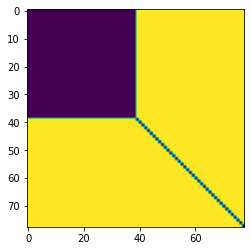

In [10]:
# Create Animate template RDM
animate_template_RDM = np.ones((78,78))
for i in range(39):
    for j in range(39):
        animate_template_RDM[i][j] = 0
for i in range(39,78):
    for j in range(39,78):
        if i == j:
            animate_template_RDM[i][j] = 0
plt.imshow(animate_template_RDM)

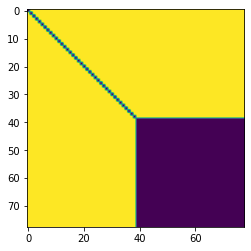

In [11]:
# Create Inanimate template RDM
inanimate_template_RDM = np.ones((78,78))
for i in range(39,78):
    for j in range(39,78):
        inanimate_template_RDM[i][j] = 0
for i in range(39):
    for j in range(39):
        if i == j:
            inanimate_template_RDM[i][j] = 0
plt.imshow(inanimate_template_RDM)

In [20]:
#RDS for each unit calculation
from scipy import stats

#plt.scatter(X[:,0],X[:,1], c=y_pred) 
model = VGG16(include_top=True, weights='imagenet', input_tensor=None,\
                input_shape=None, pooling=None, classes=1000)
    
dprime = 0.
cluster_activations = {}
cluster_activations['animate'] = np.zeros(shape=(39,13555712))
cluster_activations['inanimate'] = np.zeros(shape=(39,13555712))
for p in classes:

    im_valid_test = []
    image_list_valid = '../../data/pkl_vgg16/'+p+'_image_list_test.txt'
    with open(image_list_valid,'r') as f:
        for line in f.readlines():
            im_valid_test.append(line.strip('\n'))

    #Cluster RDM
    flag =0      
    total = 0

    for j in range(len(im_valid_test)):
        im_temp = preprocess_image_batch([im_valid_test[j]],img_size=(256,256), crop_size=(224,224), color_mode="rgb")
        print(p,j,im_valid_test[j])
        data = np.array([])

        i = 0
        for layer in model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:
                activations = get_activations(model,i,im_temp)
                temp = np.mean(activations[0], axis=0).ravel()
                if layer.name != 'predictions':
                    #print(layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape)
                    data = np.append(data, temp)
            i += 1
        cluster_activations[p][j] = data

print(cluster_activations['animate'].shape)

animate 0 ../../data/animate/ILSVRC2012_val_00032025.JPEG
animate 1 ../../data/animate/ILSVRC2012_val_00003604.JPEG
animate 2 ../../data/animate/ILSVRC2012_val_00037913.JPEG
animate 3 ../../data/animate/ILSVRC2012_val_00020432.JPEG
animate 4 ../../data/animate/ILSVRC2012_val_00013504.JPEG
animate 5 ../../data/animate/ILSVRC2012_val_00037239.JPEG
animate 6 ../../data/animate/ILSVRC2012_val_00011596.JPEG
animate 7 ../../data/animate/ILSVRC2012_val_00003116.JPEG
animate 8 ../../data/animate/ILSVRC2012_val_00024410.JPEG
animate 9 ../../data/animate/ILSVRC2012_val_00023958.JPEG
animate 10 ../../data/animate/ILSVRC2012_val_00047167.JPEG
animate 11 ../../data/animate/ILSVRC2012_val_00003822.JPEG
animate 12 ../../data/animate/ILSVRC2012_val_00017384.JPEG
animate 13 ../../data/animate/ILSVRC2012_val_00001490.JPEG
animate 14 ../../data/animate/ILSVRC2012_val_00040504.JPEG
animate 15 ../../data/animate/ILSVRC2012_val_00025566.JPEG
animate 16 ../../data/animate/ILSVRC2012_val_00013828.JPEG
animate

In [28]:
with open('../../data/'+folder+'/cluster_activations.pkl', 'wb') as handle:
     pickle.dump([cluster_activations], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
with open('../../data/'+folder+'/cluster_activations.pkl', 'rb') as handle:
     cluster_activations = pickle.load(handle)

In [45]:
#rds for each unit calculation
model = VGG16(include_top=True, weights='imagenet', input_tensor=None,\
                input_shape=None, pooling=None, classes=1000)
rds_result = {}
for label in list(set(y_pred)):
    
    #Lesioning and measuring performance
    pred = y_pred.copy()
    loc = np.where(pred==label)
    loc_temp = kmeans.predict(X_new[loc[0]])
    loc_new =[]
    for entry in set(loc_temp):
        temp = np.where(pred_kmeans==entry)[0]
        loc_new.extend(temp)
  
    print('Label: ', label, len(loc_new))
    dprime = 0.
    act = np.vstack((cluster_activations[0][classes[0]][:,loc_new],cluster_activations[0][classes[1]][:,loc_new]))
    cluster_RDM = 1 - np.corrcoef(act)    
    ana_RDS, _ = stats.kendalltau(cluster_RDM,animate_template_RDM)
    ina_RDS, _ = stats.kendalltau(cluster_RDM,inanimate_template_RDM)
    dprime = ana_RDS - ina_RDS
    
    rds_result[label] = [dprime, ana_RDS, ina_RDS]

keras.backend.clear_session()
gc.collect()
del model

Label:  0 1382269
Label:  1 4857132
Label:  2 122229
Label:  3 522735
Label:  4 4517062
Label:  5 490849
Label:  6 4386
Label:  7 1659050


In [46]:
with open('../../data/'+folder+'/rds_result_8GMM.pkl', 'wb') as handle:
     pickle.dump([rds_result], handle, protocol=pickle.HIGHEST_PROTOCOL)

32 32 0.6153846153846154 -0.8974358974358975 0.26269235589252127 -0.24025945009823463


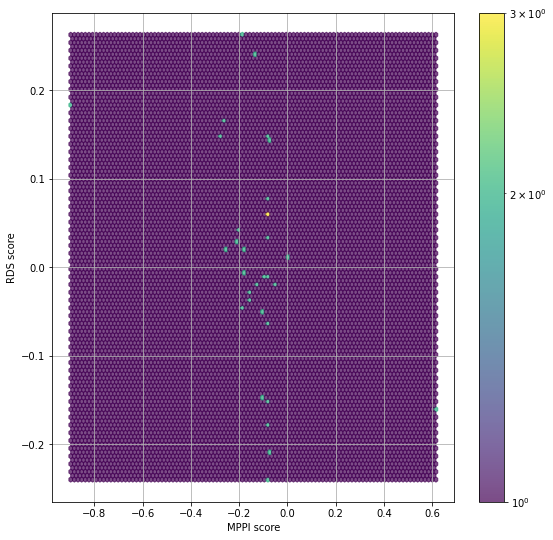

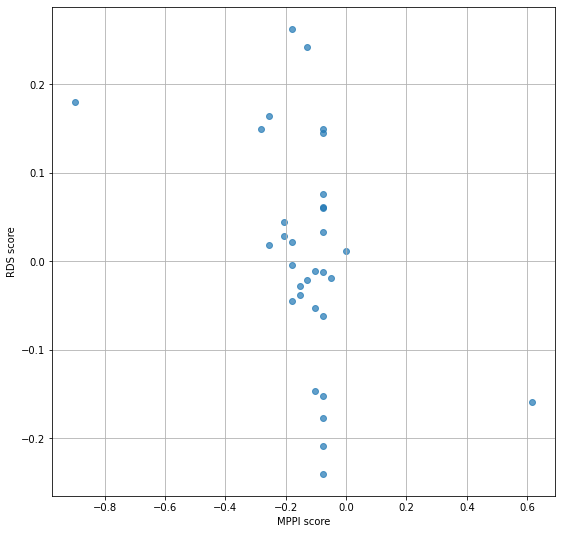

In [50]:
with open('../../data/'+folder+'/mppi_result_32GMM.pkl', 'rb') as handle:
     mppi_result = pickle.load(handle)

with open('../../data/'+folder+'/rds_result_32GMM.pkl', 'rb') as handle:
     rds_result = pickle.load(handle)

x = np.array([i[0] for i in list(mppi_result[0].values())])
y = np.array([i[0] for i in list(rds_result[0].values())])
print(len(x), len(y), max(x), min(x), max(y), min(y))

plt.figure(figsize=(9,9))
plt.hexbin(x,y,alpha=0.7, bins='log')
plt.xlabel('MPPI score')
plt.ylabel('RDS score')
plt.grid()
plt.colorbar()
#plt.xlim([-0.2,0.2])
#plt.ylim([-0.35,0.2])

plt.figure(figsize=(9,9))
plt.scatter(x,y,alpha=0.7)
plt.xlabel('MPPI score')
plt.ylabel('RDS score')
plt.grid()

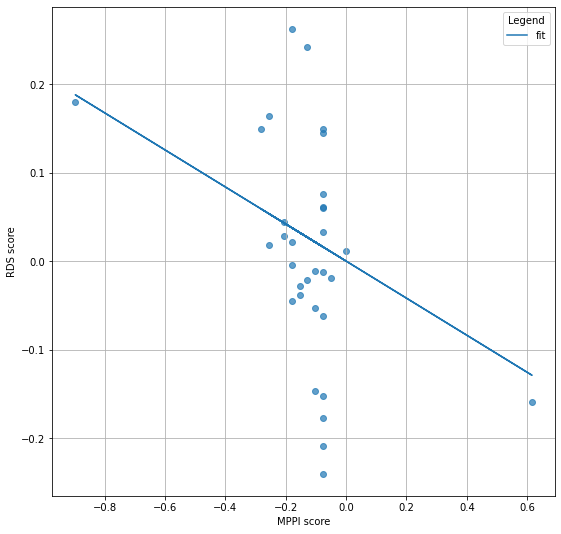

In [54]:
import scipy
def line(x, a):
    """The line of best fit."""
    # unpack the parameters:
    y = a*x
    return y

popt, pcov = scipy.optimize.curve_fit(line, x, y)

# unpack the parameters of the line of best fit:
a = popt

plt.figure(figsize=(9,9))
plt.scatter(x,y,alpha=0.7)
plt.xlabel('MPPI score')
plt.ylabel('RDS score')
plt.grid()
plt.plot(x, line(x, a), label='fit')
plt.legend(title='Legend')


In [63]:
import scipy.odr as odr
def odr_line(p, x):
    """The line of best fit."""
    # unpack the parameters:
    y = p*x
    return y

def perform_odr(x, y):
    """Finds the ODR for data {x, y} and returns the result"""
    linear = odr.Model(odr_line)
    mydata = odr.Data(x, y)
    myodr = odr.ODR(mydata, linear, beta0=[0])
    output = myodr.run()
    return output
regression = perform_odr(x, y)

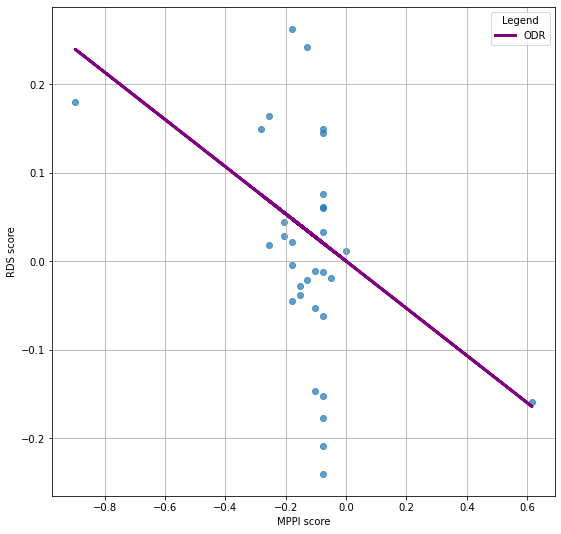

In [64]:
plt.figure(figsize=(9,9))
plt.scatter(x,y,alpha=0.7)
plt.xlabel('MPPI score')
plt.ylabel('RDS score')
plt.grid()
plt.plot(x, line(x, regression.beta[0]), label='ODR', lw=3, color='purple')
plt.legend(title='Legend')
